# Conrady Dispersion Fit – 3 Lines vs. Full Visible Spectrum

This notebook compares the accuracy of a **three‑line Conrady fit**  
using only the classical Fraunhofer F–d–C lines (486.13 nm, 587.56 nm, 656.27 nm)  
with a **multi‑line fit** that uses every refractive‑index measurement provided
for 400–700 nm in the SCHOTT glass catalogue.

For each of 10 frequently used glasses we

1. load the refractive‑index data from the Excel sheet `schott-optical-glass.xlsx`;
2. solve for the Conrady coefficients  

$$\;n(\lambda)=A+\frac{B}{\lambda}+\frac{C}{\lambda^{3.5}}$$
   with
   * only F,d,C lines and  
   * all available \(400\,\text{nm} \le \lambda \le 700\,\text{nm}\);
3. compute the root‑mean‑square (RMS) and maximum absolute error of the two fits  
   over the same visible range;  
4. collect the results in a summary table and show one detailed example.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
import warnings

In [27]:
# --- utility -------------------------------------------------------------
def conrady(lam_nm, A, B, C):
    lam_nm = np.asarray(lam_nm, float)
    return A + B/lam_nm + C/lam_nm**3.5

def fit_conrady(lam_nm, n, initial=(1.5, 1e3, 1e8)):
    lam_nm = np.asarray(lam_nm, float)
    n      = np.asarray(n, float)

    if len(lam_nm) == 3:                      # === Analytical 3-point solution ===
        M = np.column_stack([np.ones_like(lam_nm),
                             1/lam_nm,
                             1/lam_nm**3.5])
        A,B,C = np.linalg.solve(M, n)
        return A, B, C                        # No covariance, just return parameters
    else:                                     # === Standard least squares ===
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=OptimizeWarning)
            popt, _ = curve_fit(conrady, lam_nm, n,
                                 p0=initial, maxfev=10000)
        return popt

def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((y-yhat)**2))

def get_project_root() -> Path:
    """
    Return the path to the AchromatCFW project root no matter where the
    notebook/script is run from.

    •  In a Jupyter notebook  → Path.cwd() is notebooks/, so .parent is root.  
    •  In a plain .py module  → __file__ is available; go two levels up.  
    """
    if "__file__" in globals():                # running as a .py file
        return Path(__file__).resolve().parents[1]
    else:                                      # running inside Jupyter
        return Path.cwd().parent

root     = get_project_root()
xls_file = root / "references" / "schott-optical-glass.xlsx"
# -------------------------------------------------------------------------

# --- load catalogue (strip blanks, keep real header) ---------------------
def load_schott_table(xls_path: Path,
                      sheet: str = "Preferred glasses") -> pd.DataFrame:
    """Clean header whitespace so labels match the keys in `wl_map`."""
    df = pd.read_excel(xls_path, sheet_name=sheet, engine="openpyxl")
    df.columns = df.columns.str.strip()
    df["Glass"] = df["Glass"].str.strip()
    return df

data = load_schott_table(xls_file)

# wavelength dictionary (nm)
wl_map = {
    'nC': 656.272, "nC'": 643.846, 'n632.8': 632.8, 'nD': 589.3, 'nd': 587.56,
    'ne': 546.07, 'nF': 486.13, 'ng': 435.835, 'nh': 404.657
}

# Select wavelength columns that exist in the sheet
wl_cols = [c for c in wl_map if c in data.columns]

# restrict to 400‑700 nm
wl_cols_visible = [c for c in wl_cols if 400 <= wl_map[c] <= 700]

# pick ten widely used glasses (edit as desired)
common_glasses = ['N-BK7', 'F2', 'SF11', 'N-SF10', 'N-SF6', 'N-LASF9',
                  'N-BAF10', 'N-LAK22', 'N-KZFS4', 'N-FK5']

# fallback: if some names differ, use the first 10 rows
missing = [g for g in common_glasses if g not in list(data['Glass'])]
if missing:
    print("Warning – some requested glasses not found in sheet:", missing)
    common_glasses = list(data['Glass'].iloc[:10])

results = []

for glass in common_glasses:
    row = data[data['Glass']==glass].iloc[0]
    # build wavelength / n arrays
    lam_list, n_list = [], []
    for col in wl_cols_visible:
        nval = row[col]
        if not np.isnan(nval):
            lam_list.append(wl_map[col])
            n_list.append(nval)
    lam_arr = np.array(lam_list)
    n_arr   = np.array(n_list)

    # indices for F, d, C lines
    target_lines = {'nF':486.13, 'nd':587.56, 'nC':656.272}
    # safer: get exact wavelengths
    mask_fdc = np.isin(lam_arr, list(target_lines.values()))
    lam_fdc = lam_arr[mask_fdc]
    n_fdc   = n_arr[mask_fdc]

    # --- fit ---
    A_3,B_3,C_3 = fit_conrady(lam_fdc, n_fdc)
    A_full,B_full,C_full = fit_conrady(lam_arr, n_arr)

    n_pred_3   = conrady(lam_arr,  A_3,B_3,C_3)
    n_pred_all = conrady(lam_arr,  A_full,B_full,C_full)

    res = {
        'Glass': glass,
        'pts_3_RMS': rmse(n_arr, n_pred_3),
        'pts_3_max': np.max(np.abs(n_arr - n_pred_3)),
        'full_RMS' : rmse(n_arr, n_pred_all),
        'full_max' : np.max(np.abs(n_arr - n_pred_all)),
        'num_lines': len(lam_arr)
    }
    results.append(res)

summary = pd.DataFrame(results)

summary.style.format({'pts_3_RMS': '{:.1e}', 'pts_3_max':'{:.1e}',
                      'full_RMS':'{:.1e}', 'full_max':'{:.1e}'})

,Glass,pts_3_RMS,pts_3_max,full_RMS,full_max,num_lines
0,N-BK7,8.9e-06,2.3e-05,2.6e-06,5.6e-06,9
1,F2,2.9e-05,8.5e-05,7.3e-06,1.5e-05,9
2,SF11,3.3e-04,9.4e-04,7.2e-05,1.4e-04,9
3,N-SF10,2.5e-04,7.1e-04,5.4e-05,1.1e-04,9
4,N-SF6,3.7e-04,1.1e-03,8.1e-05,1.6e-04,9
5,N-LASF9,1.1e-04,3.3e-04,2.5e-05,5.0e-05,9
6,N-BAF10,2.2e-05,6.3e-05,4.3e-06,6.8e-06,9
7,N-LAK22,4.9e-05,1.4e-04,8.1e-06,1.4e-05,9
8,N-KZFS4,3.9e-06,9.7e-06,2.1e-06,4.1e-06,9
9,N-FK5,6.0e-06,1.6e-05,2.2e-06,4.6e-06,9


## Example – BK7 (3‑line vs. multi‑line fit)

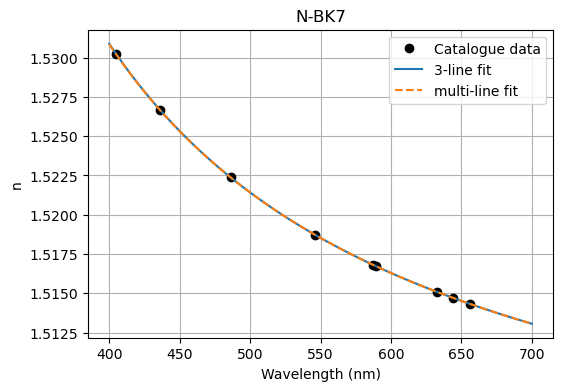

In [28]:

ex = 'N-BK7' if 'N-BK7' in common_glasses else common_glasses[0]
row = data[data['Glass']==ex].iloc[0]
lam_list, n_list = [], []
for col in wl_cols_visible:
    if not np.isnan(row[col]):
        lam_list.append(wl_map[col]); n_list.append(row[col])
lam_arr = np.array(lam_list); n_arr = np.array(n_list)
mask_fdc = np.isin(lam_arr, [486.13,587.56,656.272])
A3,B3,C3 = fit_conrady(lam_arr[mask_fdc], n_arr[mask_fdc])
Aall,Ball,Call = fit_conrady(lam_arr, n_arr)

plt.figure(figsize=(6,4))
plt.plot(lam_arr, n_arr, 'ko', label='Catalogue data')
lam_plot = np.linspace(400,700,301)
plt.plot(lam_plot, conrady(lam_plot, A3,B3,C3),  label='3‑line fit')
plt.plot(lam_plot, conrady(lam_plot, Aall,Ball,Call), '--', label='multi‑line fit')
plt.xlabel('Wavelength (nm)'); plt.ylabel('n'); plt.title(ex)
plt.legend(); plt.grid()
plt.show()


In [32]:
def model_params(row, use_lines):
    """Return (A,B,C) for given use_lines (list of λ)"""
    lam = np.array(use_lines)
    n   = np.array([row[c] for c in wl_map if wl_map[c] in use_lines])
    return fit_conrady(lam, n)

# Wavelength grid for estimating max Δn
lam_grid = np.arange(400, 700.0 + 0.5, 0.5)       # every 0.5 nm

records = []
for glass in common_glasses:
    row = data[data['Glass'] == glass].iloc[0]

    # ---------------- 3-line vs. 9-line parameters ----------------
    lam_3 = [486.13, 587.56, 656.272]                       # F-d-C
    lam_9 = [wl_map[c] for c in wl_cols_visible]            # all 9 lines

    A3,B3,C3 = fit_conrady(lam_3, [row['nF'], row['nd'], row['nC']])
    A9,B9,C9 = fit_conrady(lam_9,
                           [row[c] for c in wl_cols_visible])

    # Differences
    dA, dB, dC = A9-A3, B9-B3, C9-C3

    # Δn(λ) curve
    n3 = conrady(lam_grid, A3,B3,C3)
    n9 = conrady(lam_grid, A9,B9,C9)
    dn_max = np.max(np.abs(n9-n3))

    # Record
    records.append(dict(Glass=glass,
                        dA=dA,
                        dB=dB,
                        dC=dC,
                        dn_max=dn_max))

# -------------------------------- Results table ---------------------------------
print("The table below shows the parameter differences between 3-line and 9-line fits for 10 common glasses:")
delta_df = (pd.DataFrame(records)
              .assign(dC_1e6=lambda df: df['dC']*1e6)      # easier to read
              .drop(columns='dC')
              .rename(columns={'dC_1e6':'dC (×10⁶)',
                               'dn_max':'|Δn|max'} )
              .sort_values('|Δn|max', ascending=False)
              .reset_index(drop=True))

display(delta_df.style.format({
    'dA':'{:+.3e}', 'dB':'{:+.3e}', 'dC (×10⁶)':'{:+.2f}',
    '|Δn|max':'{:.1e}'
}))

The table below shows the parameter differences between 3-line and 9-line fits for 10 common glasses:


,Glass,dA,dB,|Δn|max,dC (×10⁶)
0,N-SF6,+3.863e-03,-3.051e+00,1.1e-03,+6204897342207.83
1,SF11,+3.353e-03,-2.651e+00,9.5e-04,+5405663897170.42
2,N-SF10,+2.584e-03,-2.039e+00,7.2e-04,+4137277933601.07
3,N-LASF9,+1.202e-03,-9.455e-01,3.3e-04,+1905369730127.00
4,N-LAK22,-5.215e-04,+4.115e-01,1.5e-04,-835689884040.61
5,F2,+3.329e-04,-2.591e-01,8.4e-05,+510589376373.59
6,N-BAF10,-2.241e-04,+1.766e-01,6.5e-05,-361577875380.12
7,N-BK7,-3.971e-05,+3.531e-02,2.4e-05,-92642868554.80
8,N-FK5,-5.893e-05,+4.543e-02,1.6e-05,-90653483752.78
9,N-KZFS4,-6.736e-05,+5.087e-02,1.0e-05,-89440447526.05
